## Processing Ocean Color Imagery

Basic goal of this notebook is to test out the full workflow and find the ideal viewing geometry

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import geopandas as gpd
import pandas as pd


import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt

import exiftool
import datetime

import rasterio

# local functions
from utils import *
from georeg import *

In [11]:
! ls data/20210407_duml_full_workflow_test/

all_imgs       sea	    sky_rededge
panel	       sea_rededge  sunblocked_rededge
panel_rededge  sky	    SYNLog-13-24-55_07-04-2021.csv


In [13]:
alta_logs = format_alta_logs('data/20210407_duml_full_workflow_test/SYNLog-13-24-55_07-04-2021.csv')
alta_logs.head()

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0,1,2,4,5,6,7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Reading IMU Time      Date  GPS Time Unnamed: 4  \
dt                                                                           
2021-04-07 13:24:55.000000      41      1.6  20210407  13:24:55        NaN   
2021-04-07 13:24:55.000001      42     1.64  20210407  13:24:55        NaN   
2021-04-07 13:24:55.000002      43     1.68  20210407  13:24:55        NaN   
2021-04-07 13:24:55.000003      44     1.72  20210407  13:24:55        NaN   
2021-04-07 13:24:55.000004      45     1.76  20210407  13:24:55        NaN   

                             Longitude   Latitude GPS Height  GPS Course  \
dt                                                                         
2021-04-07 13:24:55.000000  -766726976  347156896       1.27        18.5   
2021-04-07 13:24:55.000001  -766726976  347156896       1.27        18.5   
2021-04-07 13:24:55.000002  -766726976  347156896       1.27        18.5   
2021-04-07 13:24:55.000003  -766726976  347156896       1.27        18.5   
2021-04-07 13:24:55.000004  -766726976  347156896       1.27        18.5   

                           GPS Pos N  ...  Gyro Bias P  Gyro Bias Y  \
dt                                    ...                             
2021-04-07 13:24:55.000000     -6.43  ...     -39.3661       6.5308   
2021-04-07 13:24:55.000001     -6.43  ...     -39.3580       6.5309   
2021-04-07 13:24:55.000002     -6.43  ...     -39.3630       6.5349   
2021-04-07 13:24:55.000003     -6.43  ...     -39.3628       6.5372   
2021-04-07 13:24:55.000004     -6.43  ...     -39.3647       6.5371   

                            Accel Bias X  Accel Bias Y  Accel Bias Z  \
dt                                                                     
2021-04-07 13:24:55.000000        -0.004         0.001         0.272   
2021-04-07 13:24:55.000001        -0.004         0.001         0.272   
2021-04-07 13:24:55.000002        -0.004         0.001         0.272   
2021-04-07 13:24:55.000003        -0.004         0.000         0.273   
2021-04-07 13:24:55.000004        -0.005         0.000         0.273   

                            Extended Status  5V Alarm  Z Vibration  Checksum  \
dt                                                                             
2021-04-07 13:24:55.000000              0.0       0.0         0.04     239.0   
2021-04-07 13:24:55.000001              0.0       0.0         0.03     110.0   
2021-04-07 13:24:55.000002              0.0       0.0         0.03     138.0   
2021-04-07 13:24:55.000003              0.0       0.0         0.03      50.0   
2021-04-07 13:24:55.000004              0.0       0.0         0.03     234.0   

                            id  
dt                              
2021-04-07 13:24:55.000000   0  
2021-04-07 13:24:55.000001   1  
2021-04-07 13:24:55.000002   2  
2021-04-07 13:24:55.000003   3  
2021-04-07 13:24:55.000004   4  

[5 rows x 174 columns]

In [14]:
! ls data/20210407_duml_full_workflow_test/

all_imgs       sea	    sky_rededge
panel	       sea_rededge  sunblocked_rededge
panel_rededge  sky	    SYNLog-13-24-55_07-04-2021.csv


In [15]:
sky_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sky', 'stacks')
surface_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sea', 'stacks')

In [16]:
start = 30
count = 70

sea_imgs, sea_img_metadata = retrieve_imgs_and_metadata(surface_dir, count=70, start=30, altitude_cutoff=0)

/home/clifgray/anaconda3/envs/micasense_ocean_color/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Output shape is:  (70, 6, 1470, 2014)


In [17]:
sky_imgs, sky_img_metadata = retrieve_imgs_and_metadata(sky_dir, count=56, start=24, altitude_cutoff=0)

Output shape is:  (56, 6, 1470, 2014)


In [18]:
blocked_dir = os.path.join('data', '20210407_duml_full_workflow_test', 'sunblocked_rededge', 'stacks')

In [19]:
blocked_imgs, blocked_img_metadata = retrieve_imgs_and_metadata(blocked_dir, count=100, start=0, altitude_cutoff=0)

Output shape is:  (7, 5, 946, 1267)


In [20]:
sky_dir_re = os.path.join('data', '20210407_duml_full_workflow_test', 'sky_rededge', 'stacks')
surface_dir_re = os.path.join('data', '20210407_duml_full_workflow_test', 'sea_rededge', 'stacks')

In [21]:
sky_re_imgs, sky_re_img_metadata = retrieve_imgs_and_metadata(sky_dir_re, count=100, start=0, altitude_cutoff=0)
sea_re_imgs, sea_re_img_metadata = retrieve_imgs_and_metadata(surface_dir_re, count=100, start=0, altitude_cutoff=0)

Output shape is:  (4, 5, 946, 1267)
Output shape is:  (9, 5, 946, 1267)


Add the alta metadata onto the metadata of the open images

In [24]:
sea_img_metadata[1]

{'Latitude': 34.714955555555555,
 'Longitude': -76.67531944444445,
 'Altitude': 32.7,
 'UTC-Time': '13:28:45',
 'Date': '04/07/2021',
 'full_filename': 'data/20210407_duml_full_workflow_test/sea/stacks/8AjW2waRXumF2M32T5v4.tif',
 'filename': '8AjW2waRXumF2M32T5v4.tif',
 'yaw': 204.99308383585634,
 'pitch': 3.119862855635972,
 'roll': 8.733782000202496,
 'id': 1}

In [26]:
#grab last 4 characters of the file name:
def last_10chars(x):
    return(x[-10:])

img_fns = glob.glob('data/20210407_duml_full_workflow_test/sea' + "/*.tif")

img_fns = sorted(img_fns, key = last_10chars)

In [27]:
# TODO should automatically extract date which isn't in the md now
for item in sea_img_metadata:
    utc_time = datetime.datetime.strptime('2021-04-07-' + item['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
    img_idx = alta_logs.index.get_loc(utc_time, method='nearest')
    item['log_id'] = img_idx
    item['alta_yaw'] = (alta_logs.iloc[img_idx]['Yaw'] + 360) % 360
    # this grabs the image names based on start position and assuming 6 images (ie it is the altum)
    item['image_name'] = img_fns[start*6+item['id']*6]

only grab metadata

Open the md of each image and then sort by time and then I know the order of pitch

then I can sort by pitch and yaw

In [29]:
band_names = ['blue', 'green', 'red', 'red edge', 'nir']

In [29]:
mds = load_img_fn_and_meta(sky_dir, count=None, start=0)
len(mds)

144

In [ ]:
mds

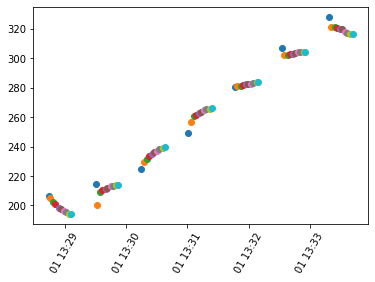

In [12]:
import datetime

for md in sea_img_metadata[:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

In [13]:
import datetime

for md in mds[24:136]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

NameError: name 'mds' is not defined

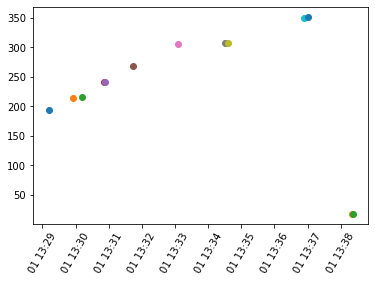

In [49]:
import datetime

for md in sky_img_metadata[2:]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['yaw'])
    plt.xticks(rotation=60)

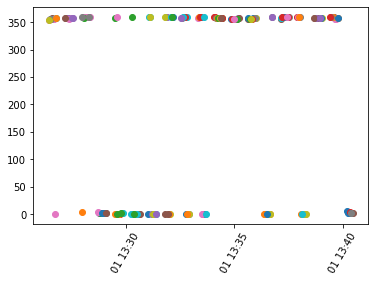

In [19]:
for md in mds:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['pitch'])
    plt.xticks(rotation=60)

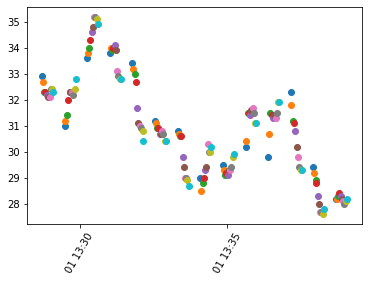

In [39]:
for md in mds[30:170]:
    plt.scatter(datetime.datetime.strptime(md['UTC-Time'], '%H:%M:%S'), md['Altitude'])
    plt.xticks(rotation=60)

In [39]:
sea_imgs.nbytes / 1e9

9.9475488

In [40]:
sky_imgs.nbytes / 1e9

7.95803904

Inspect the bands either through time or sorted by pitch/yaw/lat/ etc

In [14]:
sea_img_md_pitch_sort = sorted(sea_img_metadata[1:], key=lambda k: k['pitch'])

sky_img_md_pitch_sort = sorted(sky_img_metadata[2:], key=lambda k: k['pitch'])

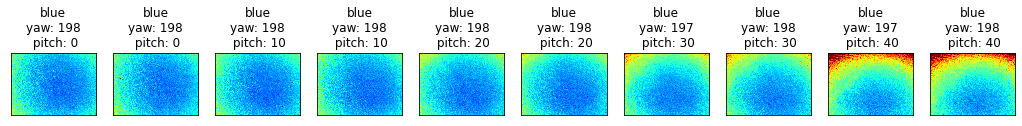

In [30]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])


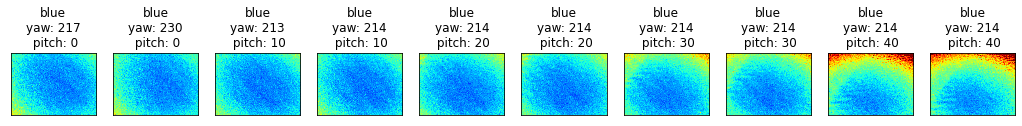

In [31]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+10]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+10][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])


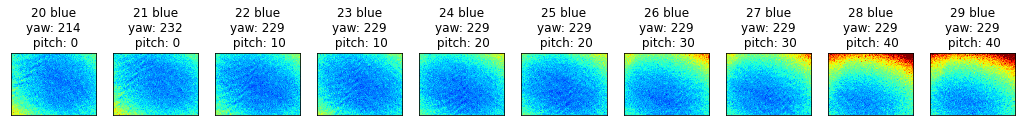

In [32]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title(str(i+20) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+20]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+20][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

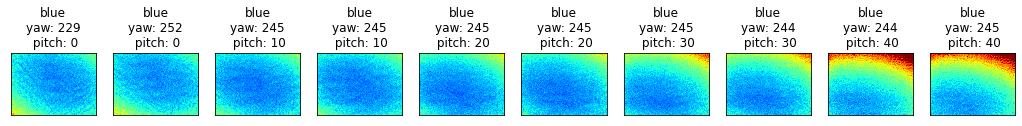

In [33]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+30]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+30][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

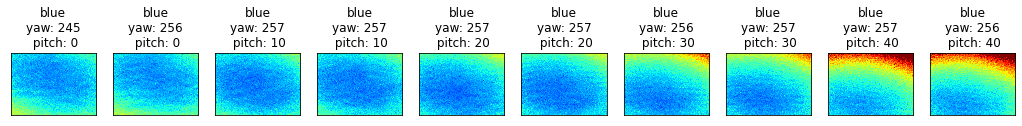

In [34]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+40]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+40][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

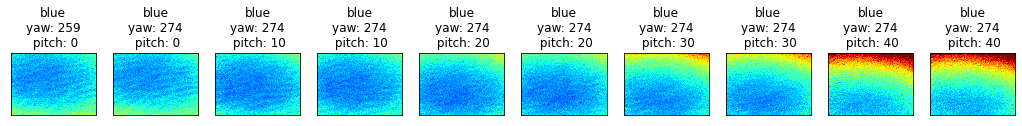

In [35]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+50]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+50][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

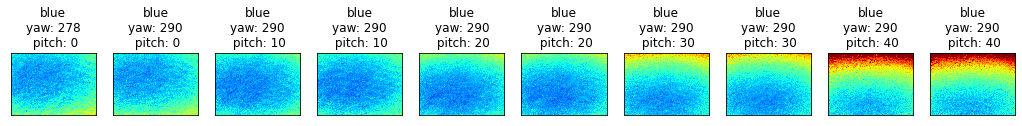

In [36]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+60]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+60][0], interpolation='none', 
                   cmap='jet', vmin=0.025, vmax=.06)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

Moving on to Green now

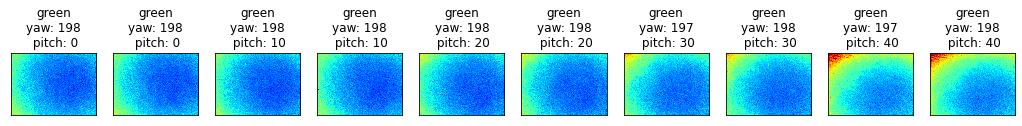

In [37]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+0]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+0][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

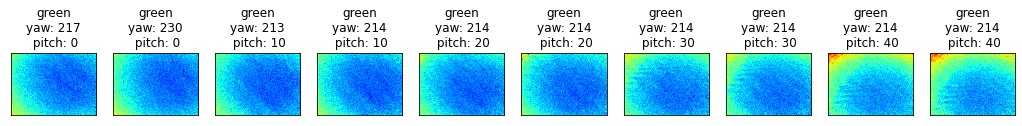

In [38]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+10]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+10][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

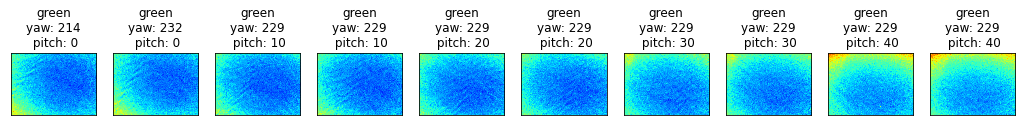

In [39]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+20]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+20][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

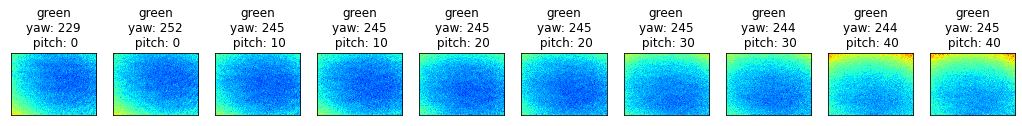

In [40]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+30]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+30][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

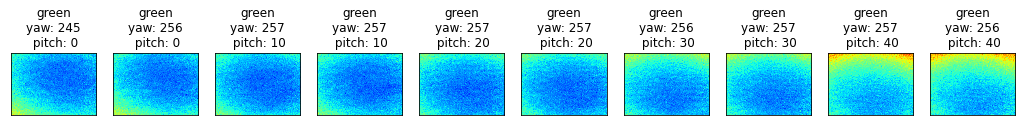

In [51]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+40]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+40][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

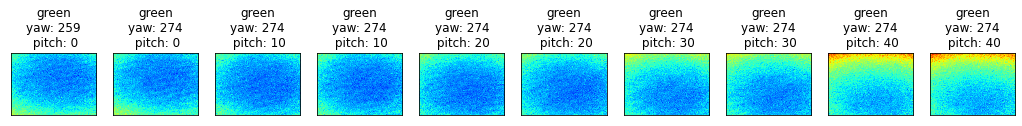

In [41]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+50]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+50][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

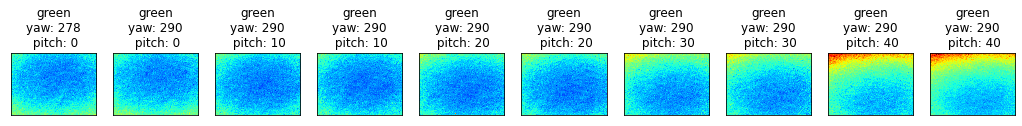

In [42]:
fig, ax = plt.subplots(1,10, figsize=(18,3))
for i in range(0,10):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+60]['alta_yaw']))+'\n pitch: '+str(0+10*int(i/2)))
    im = ax[i].imshow(sea_imgs[i+60][1], interpolation='none', 
                   cmap='jet', vmin=0.035, vmax=.08)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

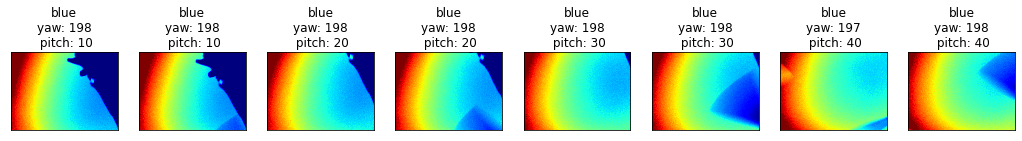

In [43]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*0]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

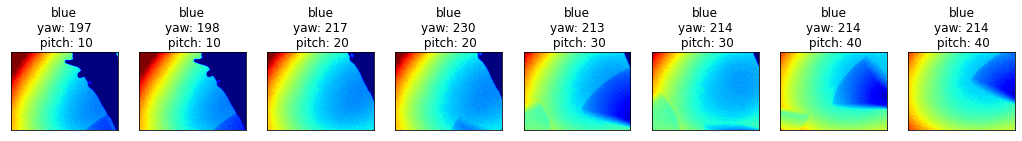

In [44]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*1]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

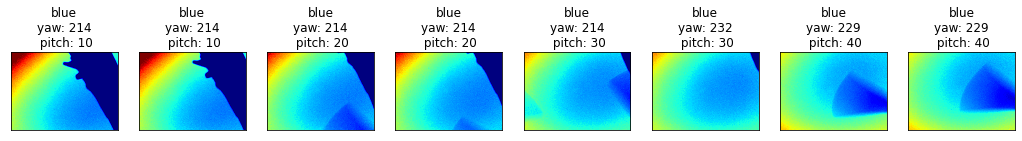

In [45]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    #ax[i].set_title('blue sky, yaw: ' + str(int(sky_img_metadata[i+8*2]['yaw'])))
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*2]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*2][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

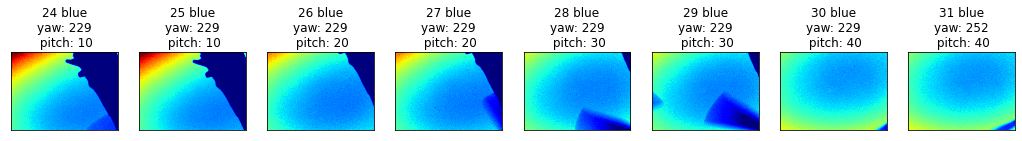

In [46]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title(str(i+8*3) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+8*3]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*3][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

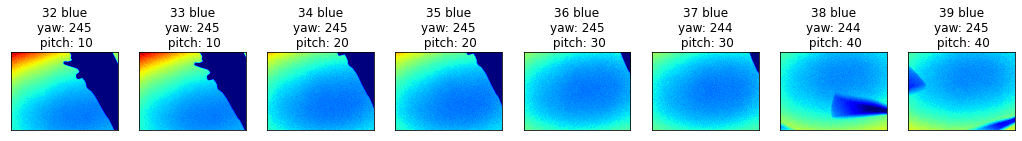

In [47]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title(str(i+8*4) + ' blue\nyaw: ' + str(int(sea_img_metadata[i+8*4]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*4][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

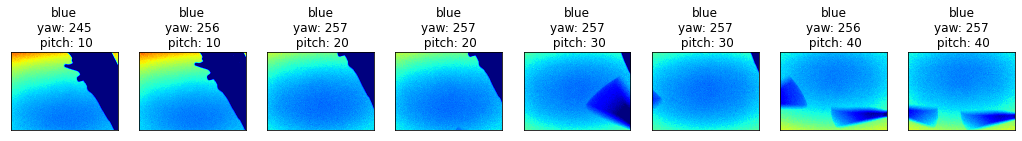

In [48]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*5]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*5][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

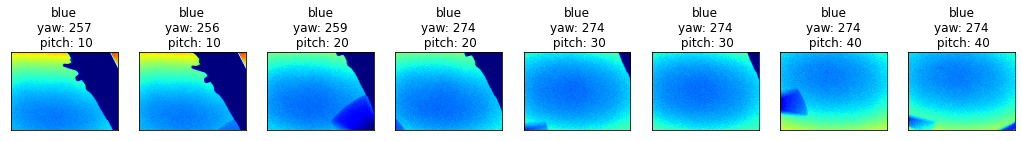

In [49]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('blue\nyaw: ' + str(int(sea_img_metadata[i+8*6]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i+8*6][0], interpolation='none', 
                   cmap='jet', vmin=0.12, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

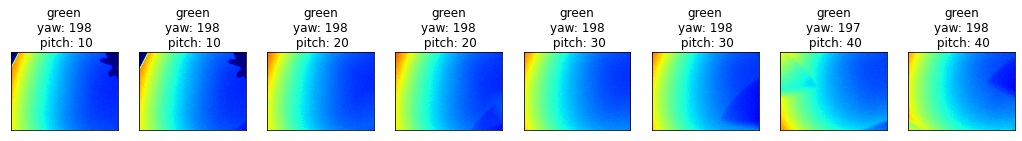

In [50]:
fig, ax = plt.subplots(1,8, figsize=(18,3))
for i in range(0,8):
    ax[i].set_title('green\nyaw: ' + str(int(sea_img_metadata[i+8*0]['alta_yaw']))+'\n pitch: '+str(10+10*int(i/2)))
    im = ax[i].imshow(sky_imgs[i][1], interpolation='none', 
                   cmap='jet', vmin=0.05, vmax=.5)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

#### inspect the sun blocked spectra based on the brightest pics there

In [94]:
blocked_imgs.shape

(7, 5, 945, 1268)

brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599
brightest pixels used: 599


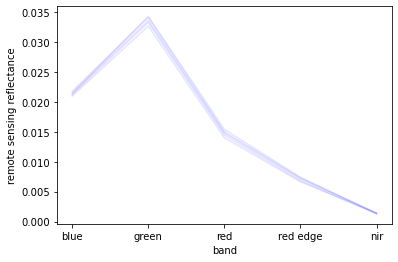

In [15]:
blocked_spectra = []
for i in range(0,5):
    spec = brightest_tube_pix(blocked_imgs[i], percent=0.0005)
    plt.plot(band_names, spec, color='blue', alpha=0.1)
    plt.ylabel('remote sensing reflectance')
    plt.xlabel('band')
    blocked_spectra.append(spec)
blocked_spectra = np.array(blocked_spectra)

### Visualize some of the rededge data for the correction

In [138]:
sky_re_imgs.shape, sea_re_imgs.shape

((4, 5, 946, 1267), (9, 5, 946, 1267))

pitch 55.22378489978678
231.59169870567823
pitch 59.981352264989084
249.39674060544104


/home/clifgray/Code/ocean_color/utils.py:434: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


pitch 59.28543112523056
248.81318506371252
pitch 59.609122592910694
248.2294867305343
pitch 59.68638973056699
246.60952223247872
pitch 61.014638603875596
242.58189136495963
pitch 55.40071388953356
240.43571902219384
pitch 55.12979555593489
239.19015596776558


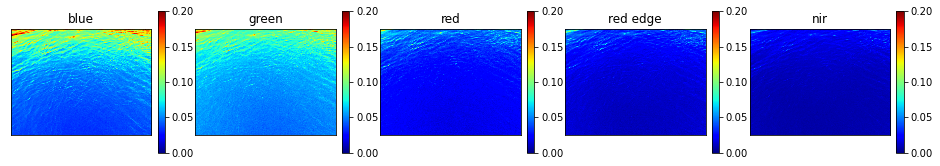

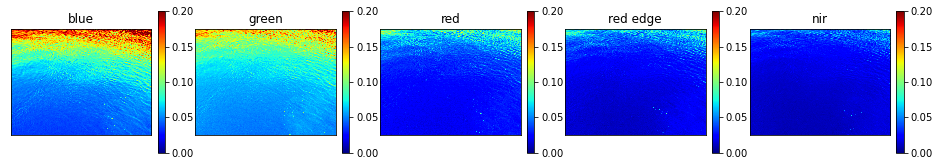

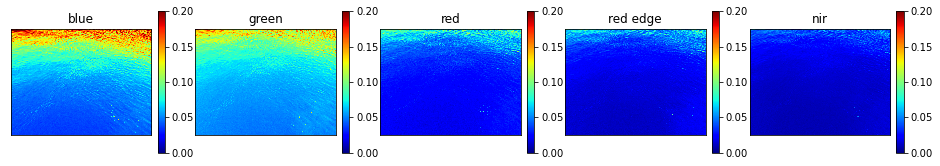

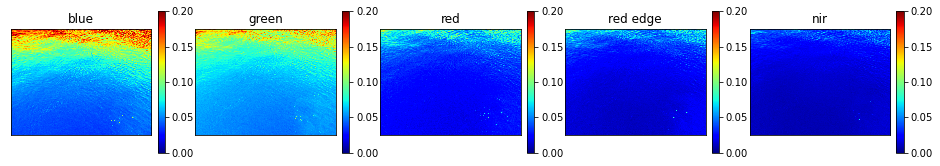

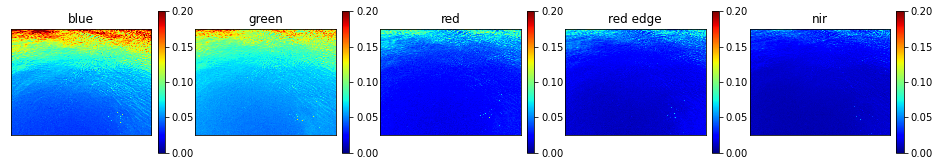

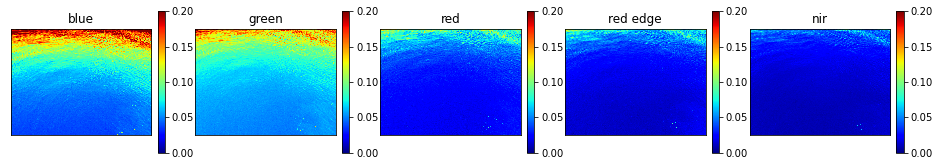

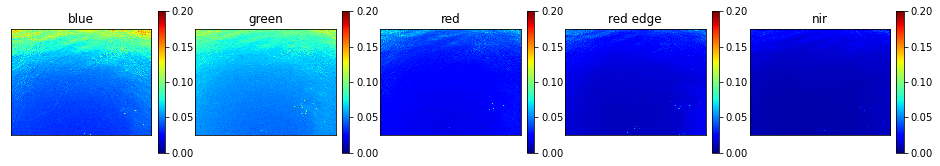

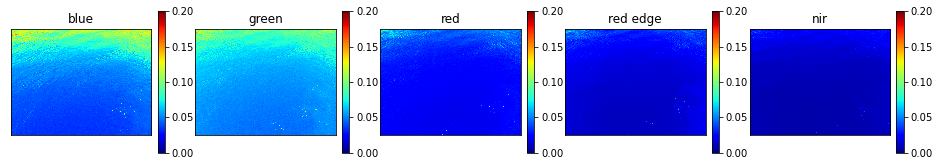

In [26]:
for i in range(0,8):
    print('pitch', sea_re_img_metadata[i]['pitch'])
    print(sea_re_img_metadata[i]['yaw'])
    visualize_darkest_pixels(sea_re_imgs[i], lowest_percent=1, max_clim=0.2, only_img=True)

pitch 37.24920074044252
57.145434939278175
pitch 39.40261551786597
54.71224316974633
pitch 45.63918681770838
53.38104661148208
pitch 42.59217228666313
56.883200578649564


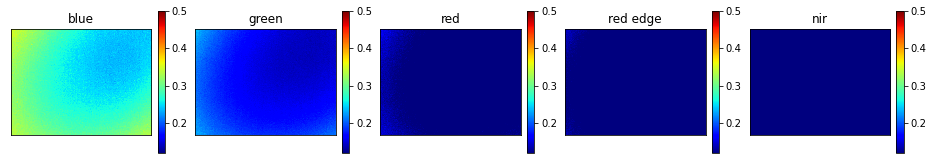

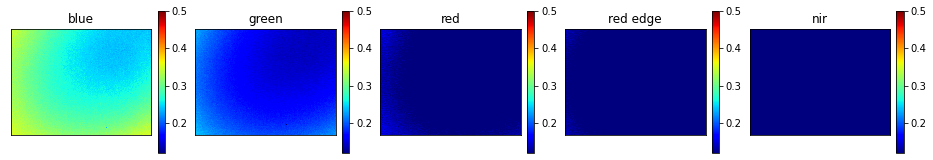

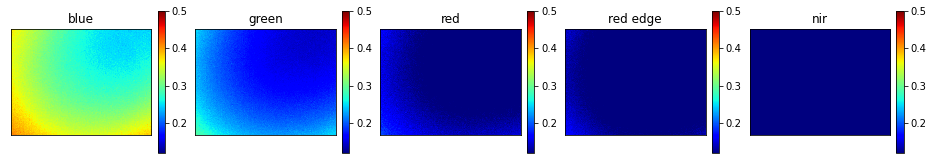

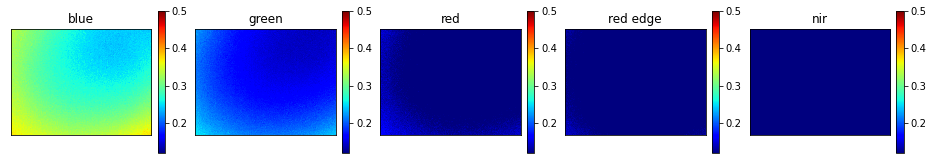

In [56]:
for i in range(0,4):
    print('pitch', sky_re_img_metadata[i]['pitch'])
    print(sky_re_img_metadata[i]['yaw'])
    visualize_darkest_pixels(sky_re_imgs[i], lowest_percent=1, min_clim=0.12, max_clim=0.5, only_img=True)

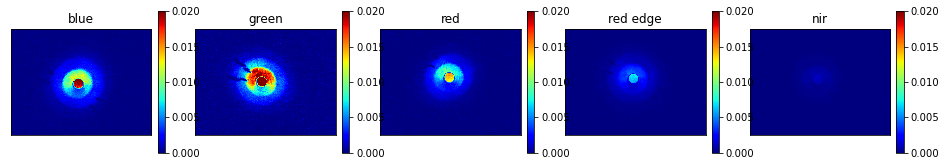

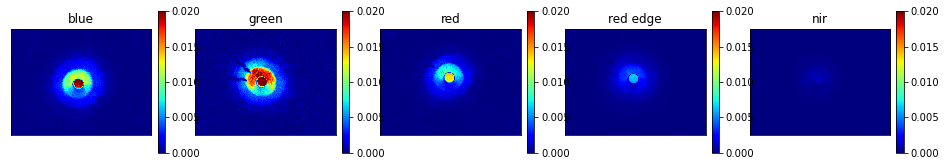

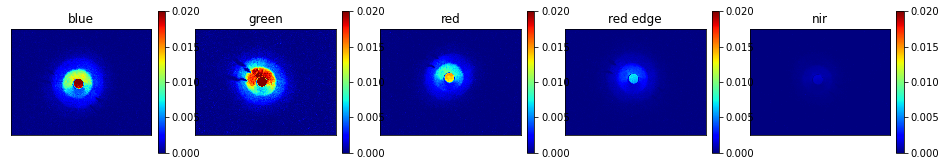

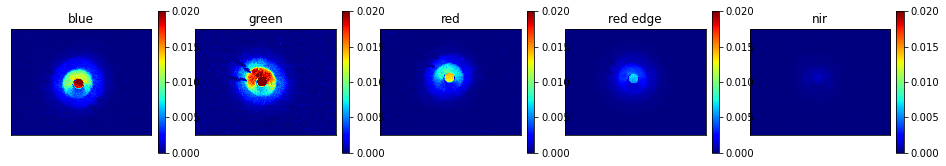

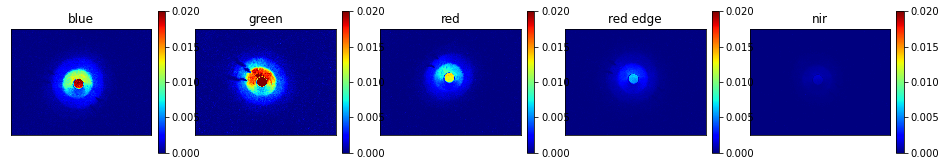

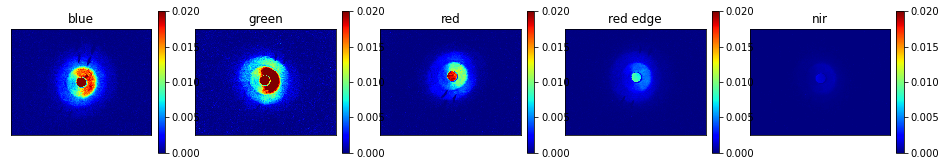

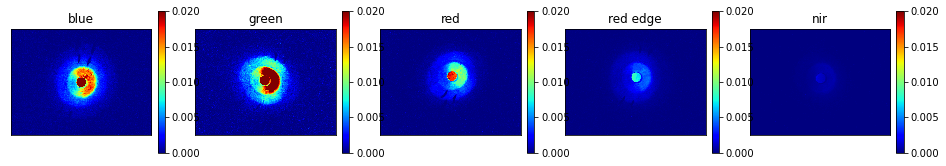

In [28]:
for i in range(0,7):
    visualize_darkest_pixels(blocked_imgs[i], lowest_percent=1, max_clim=0.02, only_img=True)

### Apply the sunblocked based approach

In [29]:
np.median(blocked_spectra,axis=0)

array([0.02212037, 0.03488749, 0.01545856, 0.00754759, 0.00149023])

#### Calculate rho by lt - lw / lsky

This is using the rededge images which seem to have some value mismatch and thus are off

(9, 5, 946, 1267)


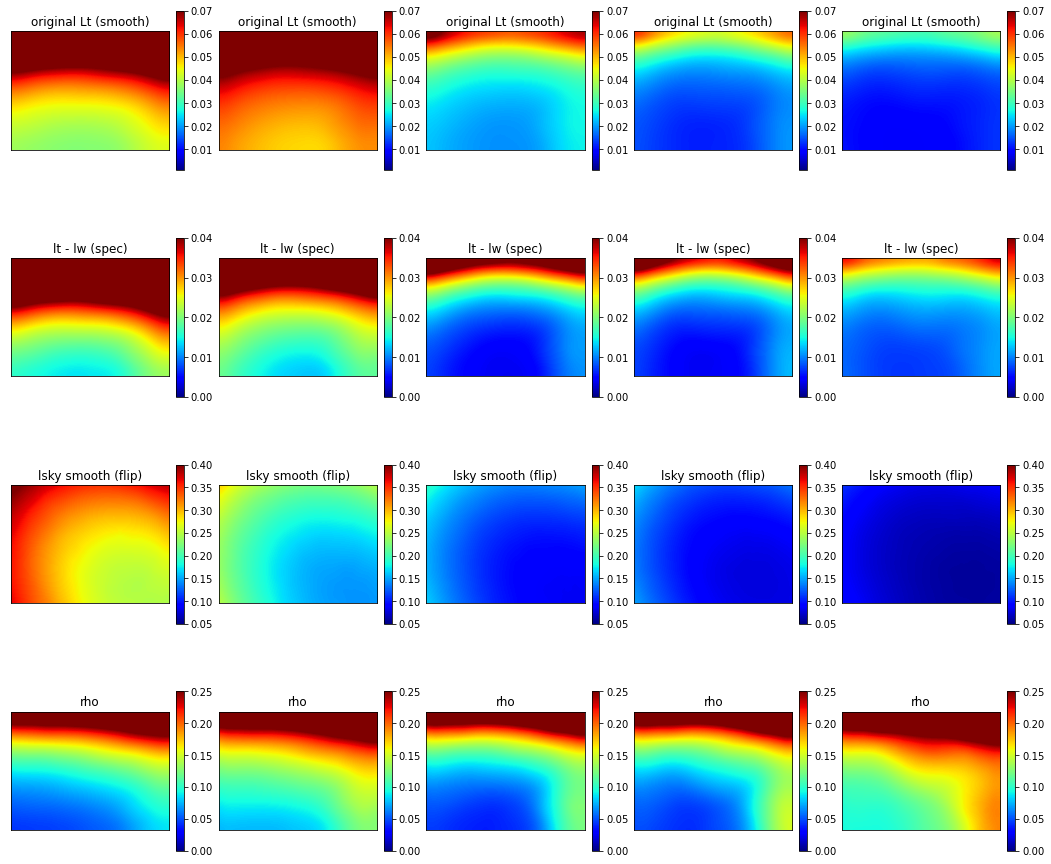

In [31]:
rho = calculate_rho(sea_re_imgs, 
              sky_re_imgs[2][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

Now using the images from the drone only

(1, 5, 1470, 2014)


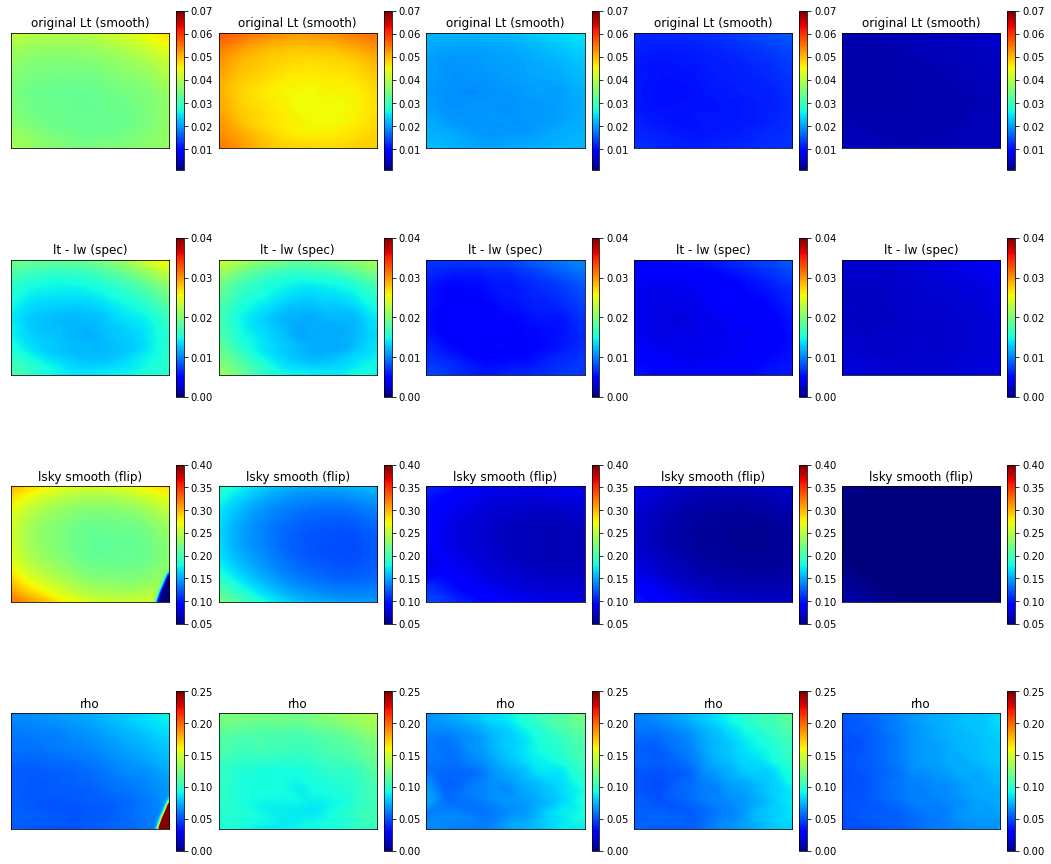

In [20]:
# trying it at the 20 degree off nadir image
rho = calculate_rho(sea_imgs[35,:5][np.newaxis,...], 
              sky_imgs[37,:5][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

(1, 5, 1470, 2014)


/home/clifgray/Code/ocean_color/utils.py:653: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


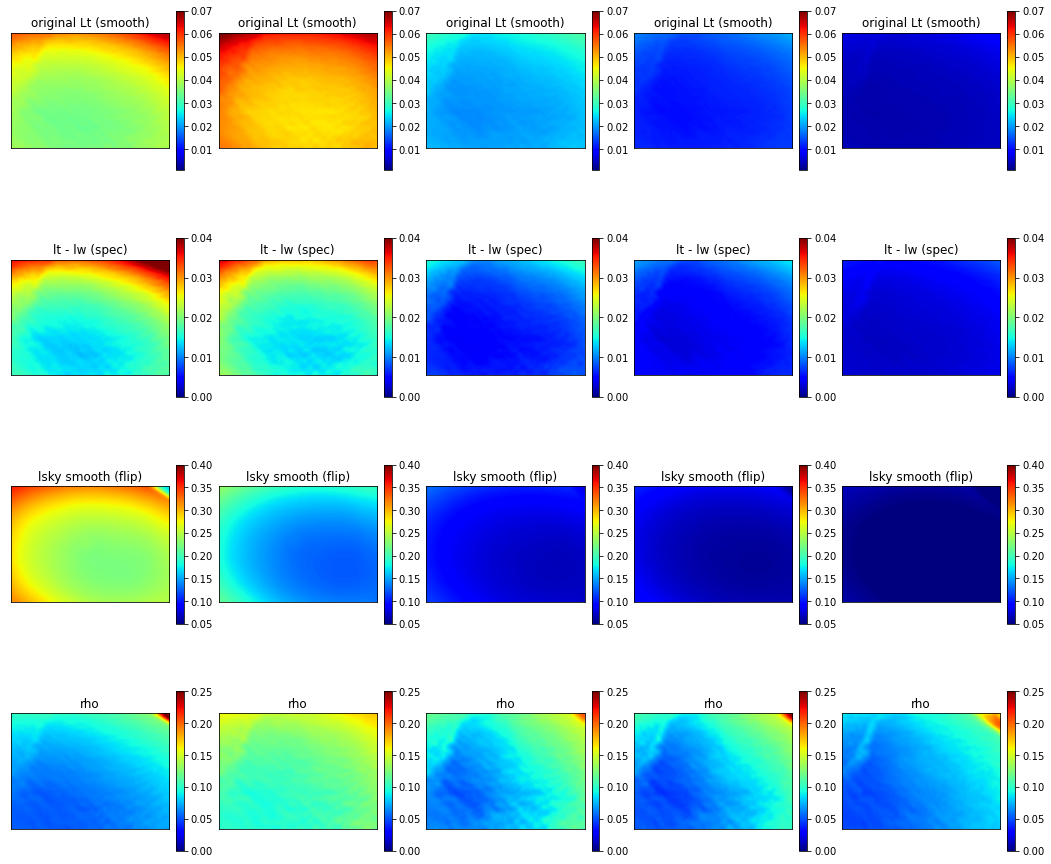

In [52]:
# this is at 135 and 40
rho = calculate_rho(sea_imgs[28,:5][np.newaxis,...], 
              sky_imgs[30,:5][np.newaxis,...], 
              np.median(blocked_spectra,axis=0), visualize=True)

(5, 1470, 2014)


/home/clifgray/Code/ocean_color/utils.py:708: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


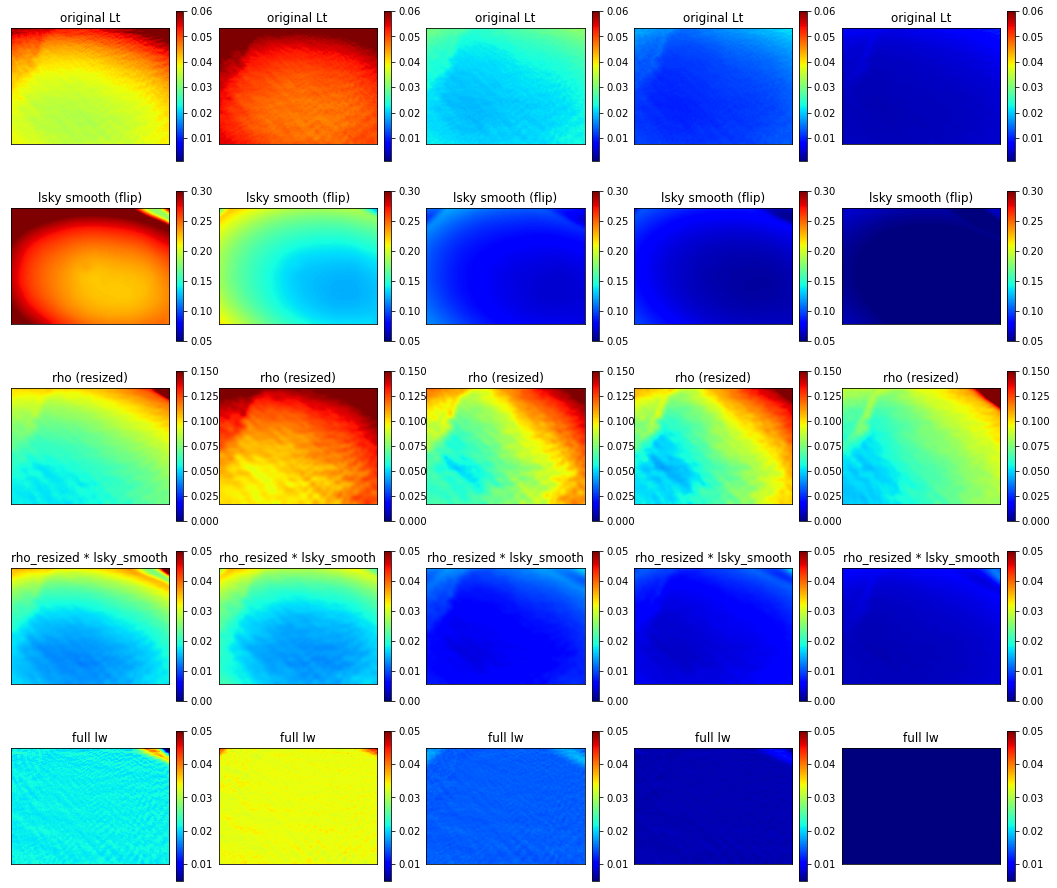

In [53]:
lw_processed = apply_rho(sea_imgs[29,:5], 
              sky_imgs[31,:5], rho, visualize=True)

#### Inspect the spectra from this

In [6]:
fig, ax = plt.subplots(figsize=(13,10))

for spectra in [np.median(sea_imgs[sea_img_md_pitch_sort[7]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='blue', alpha=0.5)
    
for spectra in [np.median(lw_processed,axis=(1,2))]:
    ax.plot(band_names, spectra, color='green', alpha=0.5)

for spectra in blocked_spectra:
    ax.plot(band_names, spectra, color='pink', alpha=0.5)
    
for spectra in [np.median(sky_imgs[sky_img_md_pitch_sort[3]['id']],axis=(1,2))]:
    ax.plot(band_names, spectra, color='lightblue', alpha=0.7)
    
#ax.plot(band_names, np.median(sky_spectra[0], axis=0), color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

NameError: name 'plt' is not defined

#### What does chla look like from these images

In [61]:
chla_lw = vec_chla_img(lw_processed[0]-lw_processed[4], lw_processed[1]-lw_processed[4])

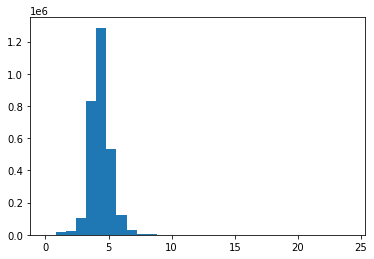

In [62]:
plt.hist(chla_lw.flatten(), bins=30)
plt.show()

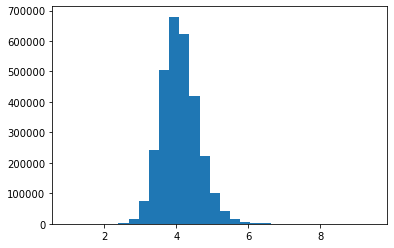

In [30]:
plt.hist(chla_lw.flatten(), bins=30)
plt.show()

In [24]:
chla_lw[300:, 100:-100].shape

(1170, 1814)

In [57]:
np.nanmedian(chla_lw)

4.065873429901383

In [26]:
np.median(chla_lw[300:, 100:-100])

4.070752121352445

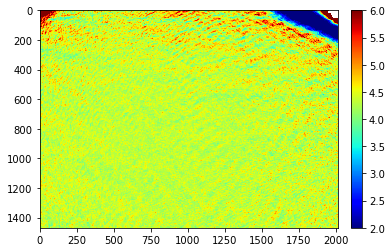

In [63]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw, cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

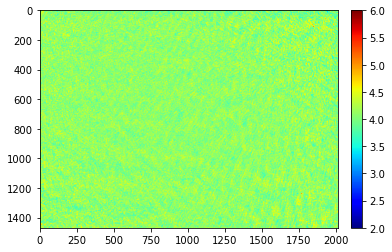

In [31]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw, cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

In [32]:
chla_lw.shape

(1470, 2014)

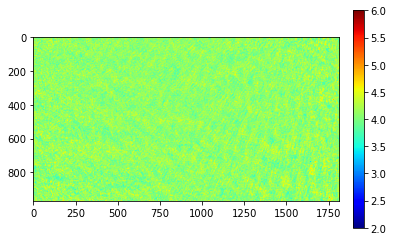

In [33]:
fig,ax = plt.subplots()
im = ax.imshow(chla_lw[500:, 100:-100], cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

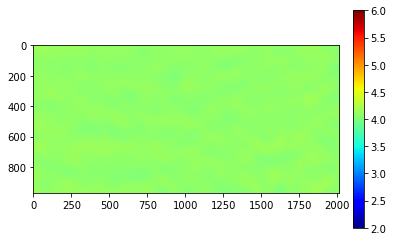

In [34]:
fig,ax = plt.subplots()
im = ax.imshow(ndimage.gaussian_filter(chla_lw[500:, :], sigma=(30, 30), order=0), cmap='jet', vmin=2,vmax=6)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

#### Now visualize a bunch of images and the chla from them

### Chlorophyll retrieval algorithm

Run chla retrieval on water leaving spectra

In [66]:
chla_list = []
for spectra in blocked_spectra:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[6.356087606017864,
 6.258882462214956,
 6.555905398674276,
 6.437045009156115,
 6.0705909634053805,
 6.0467082739748275,
 6.1363390346805025]

In [67]:
chla_list = []
for spectra in water_leaving_spec:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)
chla_list

[3.725178152219733]

In [294]:
4.50674749003831 / 3.778

1.1928924007512731

In [68]:
for md in sea_img_metadata[:]:
    print(md['pitch'])

24.48100439092184
18.278774752899437
16.62868657249811
30.335922246084635
34.914430565022315
37.5013787624174
34.73575007534288
45.9768427574661
51.218735490343306
57.236565622612886
52.02441024442453
46.67323453974166
42.0941159243867
37.69342367764301
29.24397755315249
49.92532694279146


### Save spectra and chla values as a geopandas dataframe along with image metadata

In [69]:
# TODO need to filter out for bad lat and lon and bad chl values
# it seems like sometimes lat and long are 0

In [ ]:
gdf = convert_to_ocean_color_gdf(chla_list, water_leaving_spec, [sea_img_metadata[i] for i in sea_idxs])
print(len(gdf))
gdf.head()

In [ ]:
import contextily as ctx
gdf.set_crs(epsg=4326, inplace=True)
web_merc_gdf = gdf.to_crs(epsg=3857)
fig,ax = plt.subplots(figsize=(12,12))
web_merc_gdf.plot(ax=ax, column='chla', vmax=6, vmin=3)
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world.plot(ax=ax)
ctx.add_basemap(ax, zoom=12)
ax.set_ylim(4123102,4126102)
ax.set_xlim(-8537315, -8532315)

Save out the file

In [185]:
gdf.time = gdf.time.astype(str)
gdf.spectra = gdf.spectra.astype(str)
#gdf.to_file('data/260920_shearwateroffshore_dual/uas_data_260920_1_dark.shp')